In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster, predict_cf, calculate_ite, get_homogeneity



In [5]:
np.random.seed(seed = 0)

In [6]:
pd.set_option("display.max_columns", None)


In [7]:
x_partition = [[i,i**2,2*i**4, 50000] for i in [2,4,5,10,12,20,25,33]]
def its(x):
    for i, (x1,x2,x3,x4) in enumerate(x[1:]):
        x[i+1][3]=(int(x[i][3]/(2*np.sqrt(x3/x[i][2]))))
    return x

In [8]:
a = its(x_partition)
exps = pd.DataFrame(a, columns = ['X-parts','Clusters', 'N', 'iters'])

In [9]:
name = 'box'
exps.index.name = name

In [10]:
exps['mean-hom'] = 0
exps['std-hom'] = 0

In [11]:
exps

,X-parts,Clusters,N,iters,mean-hom,std-hom
box,,,,,,
0,2,4,32,50000,0,0
1,4,16,512,6250,0,0
2,5,25,1250,2000,0,0
3,10,100,20000,250,0,0
4,12,144,41472,86,0,0
5,20,400,320000,15,0,0
6,25,625,781250,4,0,0
7,33,1089,2371842,1,0,0


In [12]:
import time

In [13]:
%%time
col_select = ['x0', 'x1']
gen = []
for i,row in exps.iterrows():
    c, n, iters = row.Clusters, row.N, row.iters
    homc = []
    print('running:',c,n)
    ss = time.time()
    for j in range(iters):
        ###gneerate data
        N,D = n, 2
        x = int((N)**(1/4))
        clusters = x**2
       # print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
        kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
        centers = [[0.5,0.5],[0.5,0.5]]
        r_small = [0, 0.325735]
        r_big = [0.325735,0.46065886]
        eligibilities = [2,1]
        kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
                       'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
        kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

        std = 5
        stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                          [2, std]])
        kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

        data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
        data = calculate_ite(data.copy(), treatment = 'Treatment',
                             counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')
        ### cluster data
        data2,_ = box_clustering(data, clusters=c,col_select = col_select, cluster_name = 'A')
        ### calc hom
        res = computeATT_per_cluster(data2.copy(), hom_name = 'HOM',weight_names = 'W', 
                                     cluster_name  = "A", att = False)
        hom = (res['HOM']*res['W']).sum(axis = 0)
        homc.append(hom)
        
    ###get stats
    ee = time.time() - ss
    print('time:',ee)
    homcnp = np.array(homc)
    gen.append(homcnp)
    mean = np.mean(homcnp)
    std = np.std(homcnp)
    exps.loc[i,'mean-hom'] = mean
    exps.loc[i,'std-hom'] = std
    
    

running: 4 32
time: 1936.797171831131
running: 16 512
time: 407.54148292541504
running: 25 1250
time: 171.16905522346497
running: 100 20000
time: 66.04196214675903
running: 144 41472
time: 32.483460664749146
running: 400 320000
time: 17.243164777755737
running: 625 781250
time: 8.314166784286499
running: 1089 2371842
time: 5.569547653198242
CPU times: user 44min 1s, sys: 5.85 s, total: 44min 7s
Wall time: 44min 5s


In [31]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3


In [32]:
exps.head()

,X-parts,Clusters,N,iters,mean-hom,std-hom,std-err
box,,,,,,,
0,2,4,32,50000,0.508666,0.052547,0.009289
1,4,16,512,6250,0.741927,0.019040,0.000841
2,5,25,1250,2000,0.761064,0.010822,0.000306
3,10,100,20000,250,0.882046,0.002272,0.000016
4,12,144,41472,86,0.893937,0.001355,0.000007


In [33]:
exps['std-err'] = exps['std-hom']/np.sqrt(exps['N'])

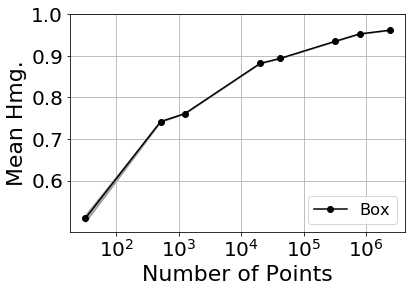

In [38]:
y = 'mean-hom'
x = 'N'
z = 'std-err'
box = exps
fig, ax = plt.subplots()
line1 = ax.plot(box[x],box[y], 'k-o')
ax.fill_between(box[x], box[y]-box[z], box[y]+box[z], color = 'k', alpha = 0.3)
#line2 = ax.plot(km[x],km[y],'k--')
#ax.fill_between(km[x], km[y]-km[z], km[y]+km[z], alpha = 0.3, color = 'k')
ax.set_yticks(np.arange(0.6,1.05,0.1))
ax.set_xscale('log')
ax.set_xticks([ 100, 1000, 10000, 100000, 1000000])
ax.legend(['Box'], loc = 'lower right')
ax.set_xlabel('Number of Points')
ax.set_ylabel('Mean Hmg.')
ax.grid(visible = True)
plt.minorticks_off()
fig.savefig('{}/std5PCM.pdf'.format(p), bbox_inches='tight',pad_inches = 0)

fig.show()

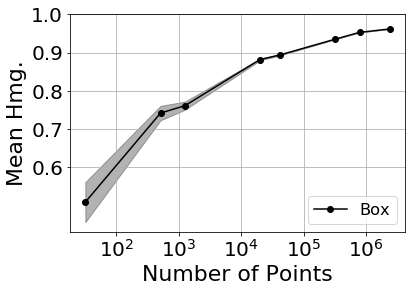

In [37]:
y = 'mean-hom'
x = 'N'
z = 'std-hom'
box = exps
fig, ax = plt.subplots()
line1 = ax.plot(box[x],box[y], 'k-o')
ax.fill_between(box[x], box[y]-box[z], box[y]+box[z], color = 'k', alpha = 0.3)
#line2 = ax.plot(km[x],km[y],'k--')
#ax.fill_between(km[x], km[y]-km[z], km[y]+km[z], alpha = 0.3, color = 'k')

ax.set_yticks(np.arange(0.6,1.05,0.1))
ax.set_xscale('log')
ax.set_xticks([ 100, 1000, 10000, 100000, 1000000])
ax.legend(['Box'], loc = 'lower right')
ax.set_xlabel('Number of Points')
ax.set_ylabel('Mean Hmg.')
ax.grid(visible = True)
plt.minorticks_off()
fig.savefig('{}/std5PCM_V2.pdf'.format(p), bbox_inches='tight',pad_inches = 0)

fig.show()

In [15]:
from pathlib import Path



In [16]:
p = './homogstd5/'
Path('./homogstd5/').mkdir(parents = True, exist_ok = True)
exps.to_csv(p+name+'.csv')
